In [1]:
import cv2
import glob
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint
import albumentations as A
import torch.optim as optim
from torch.nn import BCELoss
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from segmentation.models import all_models
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

plt.style.use("dark_background")

c:\Users\Aditya Bapat\Desktop\project\brain-tumor-segmentation-project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing Dataset

In [2]:
# Path to all data
DATA_PATH = "./dataset/kaggle_3m/"

# img size
IMG_SIZE = 512

In [3]:
# Raw data
import os
import glob
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

This is not a dir: ./dataset/kaggle_3m\data.csv
This is not a dir: ./dataset/kaggle_3m\README.md


,dirname,path
0,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_CS_4941_19960909/TCGA...
1,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_CS_4941_19960909/TCGA...
2,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_CS_4941_19960909/TCGA...
3,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_CS_4941_19960909/TCGA...
4,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_CS_4941_19960909/TCGA...


Exploratory Data Analysis

In [4]:
# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

print(df_imgs["path"].values[0][50: -4])
print(df_masks["path"].values[0][50:-9])

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[slice(55, -9)]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[slice(55, -9)]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

4941_19960909_1
4941_19960909_10
Path to the Image: ./dataset/kaggle_3m\TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_41.tif 
Path to the Mask: ./dataset/kaggle_3m\TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_27_mask.tif


In [5]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

,patient,image_path,mask_path,diagnosis
0,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,0
1,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,0
2,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,0
3,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,0
4,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,0
...,...,...,...,...
3924,kaggle_3m\TCGA_HT_A61B_19991127,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,0
3925,kaggle_3m\TCGA_HT_A61B_19991127,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,0
3926,kaggle_3m\TCGA_HT_A61B_19991127,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,0
3927,kaggle_3m\TCGA_HT_A61B_19991127,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,0


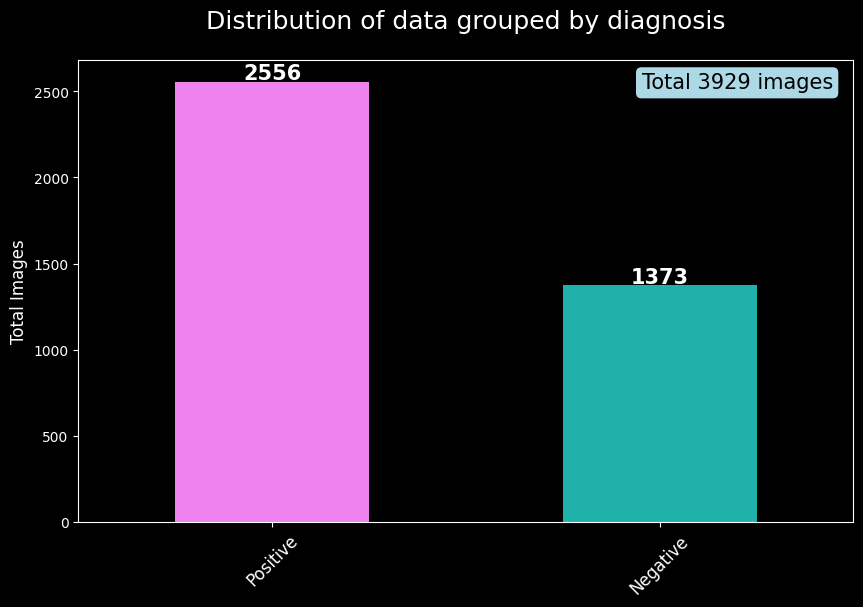

In [6]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

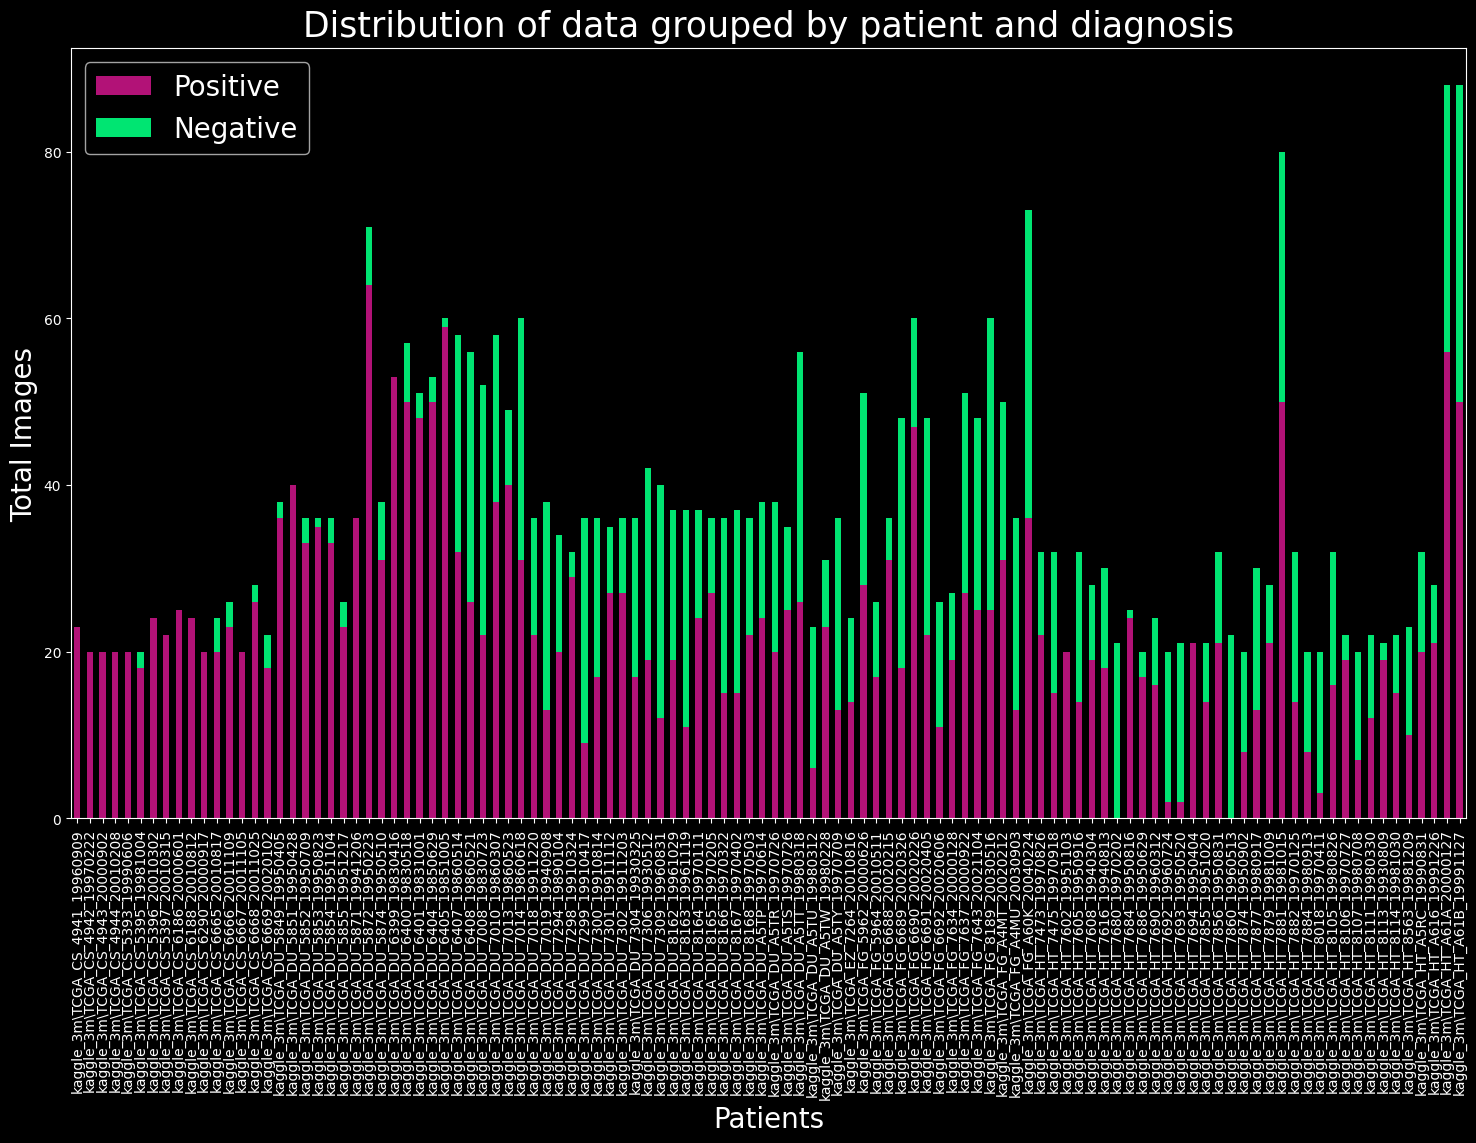

In [7]:
# Data
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

# Annotations
"""for i, rows in enumerate(patients_by_diagnosis.values):
    plt.annotate(int(rows[0]), xy=(i, rows[0]+1), rotation=90, color="white")
    plt.annotate(int(rows[1]), xy=(i, rows[1]+1), rotation=90, color="aqua")""";

Data Visualization

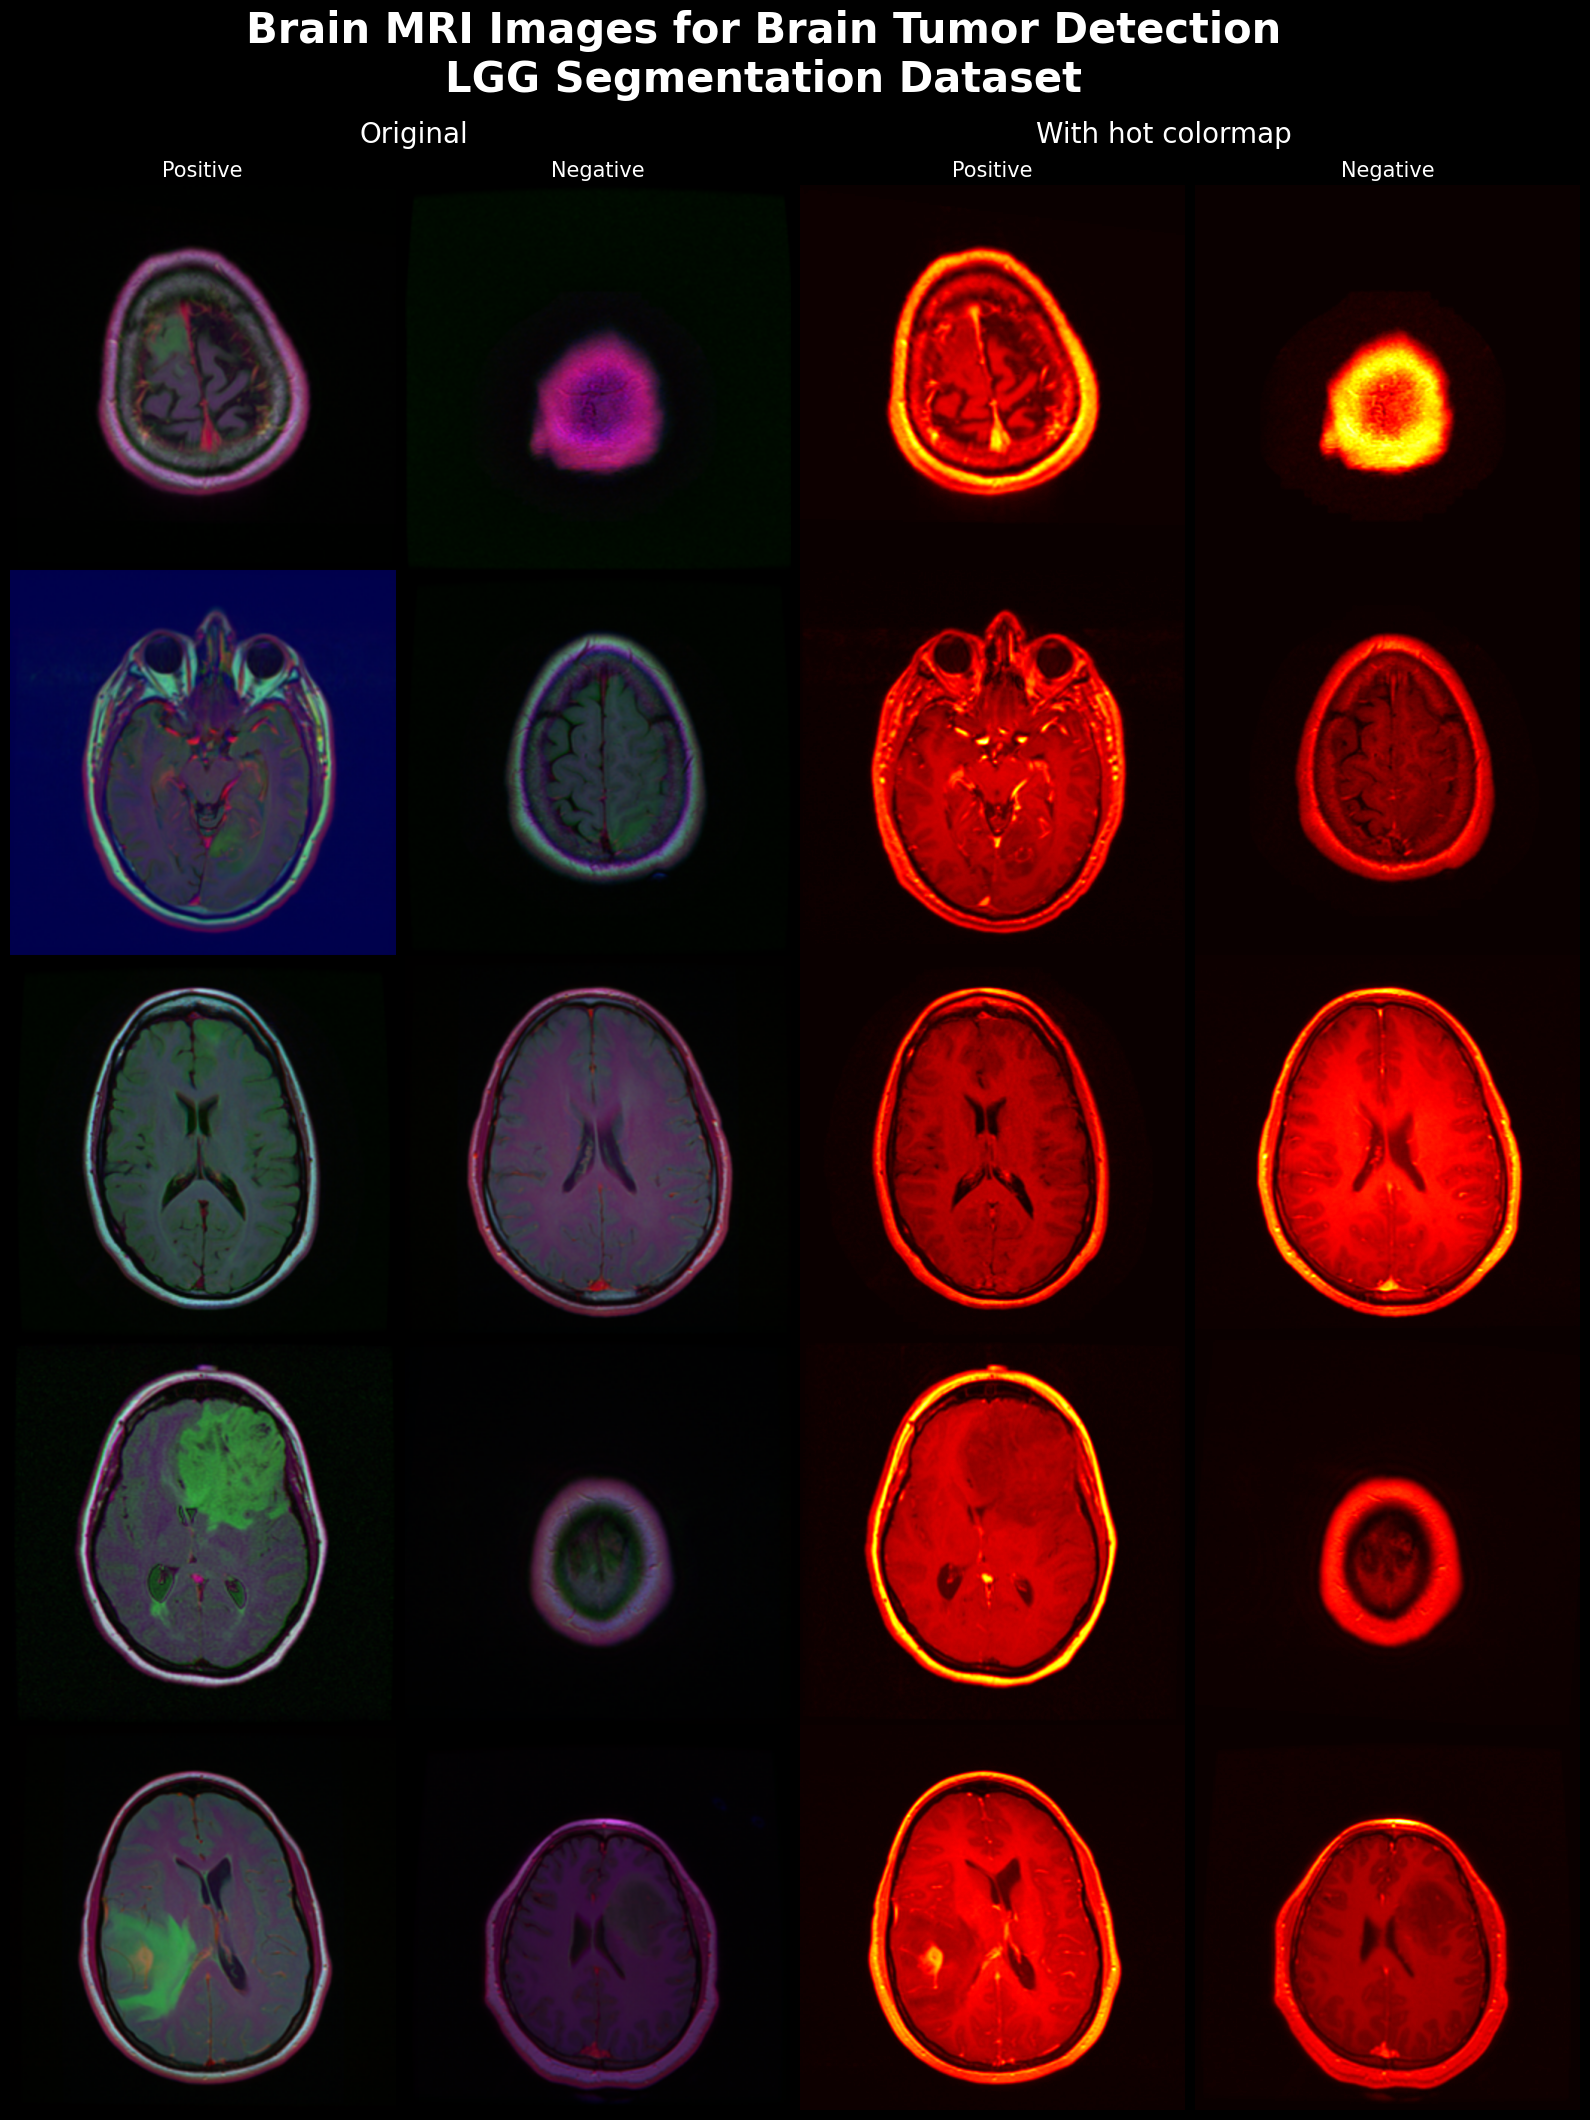

In [8]:
# Data
sample_yes_df = df[df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = df[df["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset_image.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

Samples of images and masks with a positive diagnosis

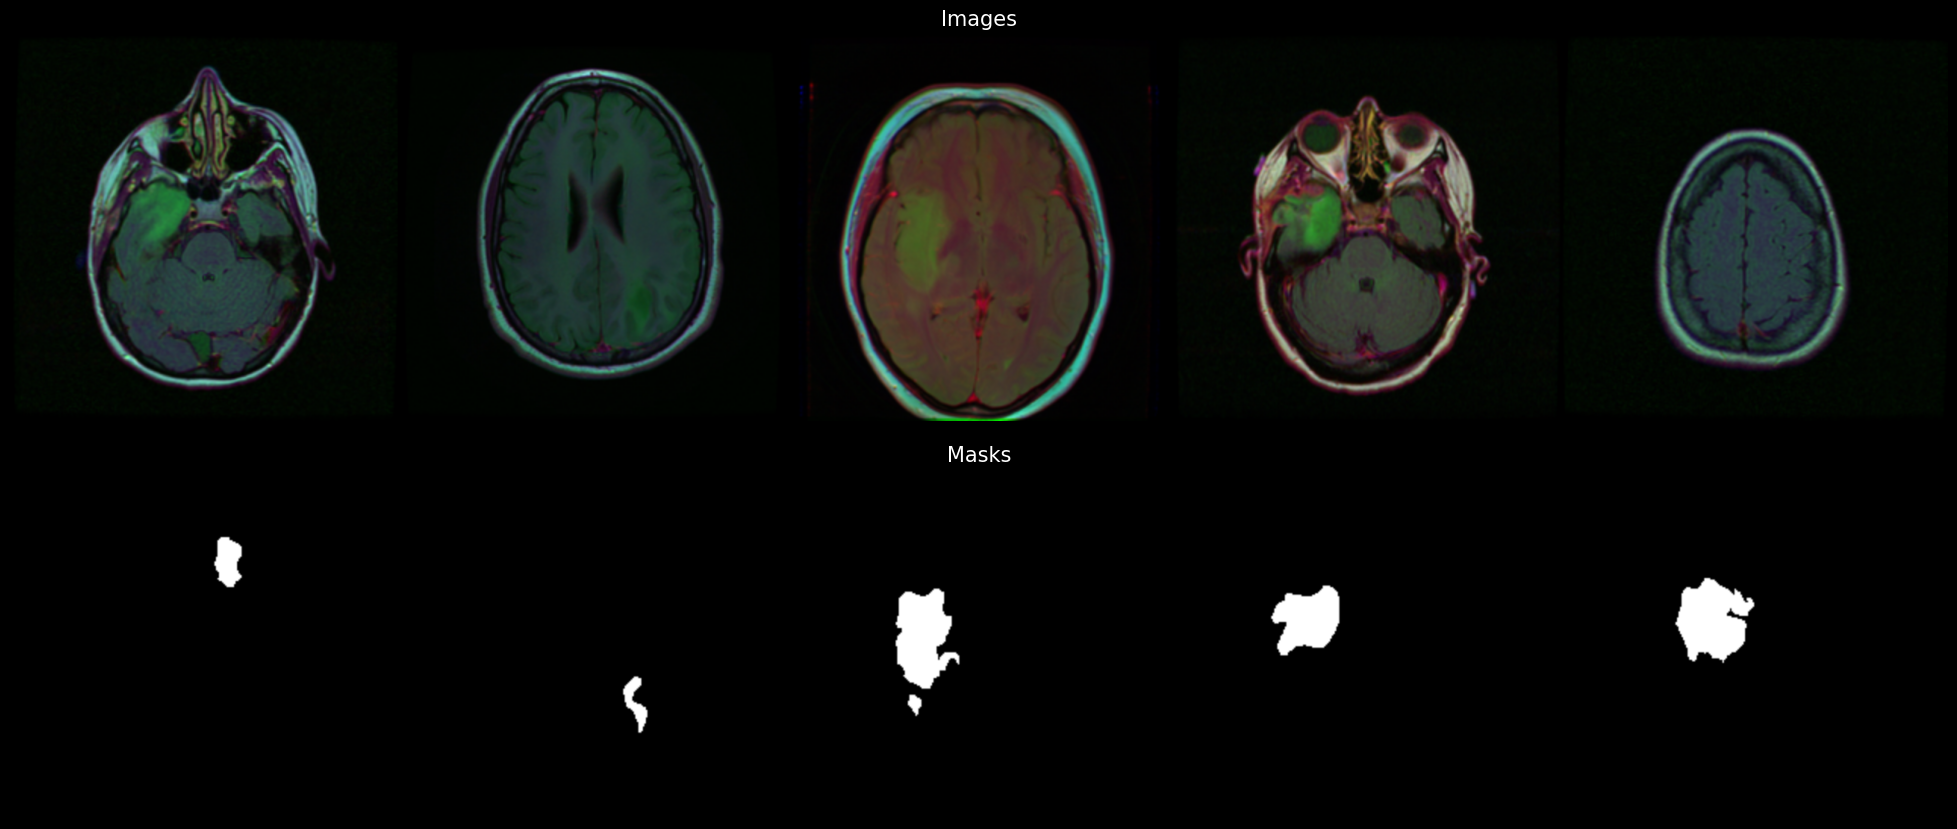

In [9]:
# Data
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()

DataGenerator and Data Augmentation

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import train_test_split

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

DataGenerator

In [12]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):
        
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)

        augmented = self.transforms(image=image, 
                                    mask=mask)
 
        image = augmented['image']
        mask = augmented['mask']   
        
        return image, mask
    
        # unnormilize mask
        #mask = torch.clamp(mask.float(), min=0, max=1)
        #mask = torch.ceil(mask)       

transforms

Split data on train val test

In [13]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [14]:
PATCH_SIZE = 128 #256

strong_transforms = A.Compose([
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),
    
    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    ], p=0.8),
    
    
    A.Normalize(p=1.0),
    #https://albumentations.readthedocs.io/en/latest/api/pytorch.html?highlight=ToTensor#albumentations.pytorch.transforms.ToTensor
    ToTensorV2(),
])


transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    
    
    A.Normalize(p=1.0),
    ToTensorV2(),
])

c:\Users\Aditya Bapat\Desktop\project\brain-tumor-segmentation-project\venv\lib\site-packages\albumentations\imgaug\transforms.py:174: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)


In [15]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=4, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=4, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=4, shuffle=True)

Augmentation Visualization

In [16]:
# def show_aug(inputs, nrows=5, ncols=5, image=True):
#     plt.figure(figsize=(10, 10))
#     plt.subplots_adjust(wspace=0., hspace=0.)
#     i_ = 0
    
#     if len(inputs) > 25:
#         inputs = inputs[:25]
        
#     for idx in range(len(inputs)):
    
#         # normalization
#         if image is True:           
#             img = inputs[idx].numpy().transpose(1,2,0)
#             mean = [0.485, 0.456, 0.406]
#             std = [0.229, 0.224, 0.225] 
#             img = (img*std+mean).astype(np.float32)
#         else:
#             img = inputs[idx].numpy().astype(np.float32)
#             img = img[0,:,:]
        
#         #plot
#         #print(img.max(), len(np.unique(img)))
#         plt.subplot(nrows, ncols, i_+1)
#         plt.imshow(img); 
#         plt.axis('off')
 
#         i_ += 1
        
#     return plt.show()

    
# images, masks = next(iter(train_dataloader))
# print(images.shape, masks.shape)

# show_aug(images)
# show_aug(masks, image=False)

Model Zoo

UNET Model

![UNET](https://miro.medium.com/max/1400/1*f7YOaE4TWubwaFF7Z1fzNw.png)

In [17]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

In [18]:
class UNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
                
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(128 + 64, 64)
        
        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
        
    def forward(self, x):
        # Batch - 1d tensor.  N_channels - 1d tensor, IMG_SIZE - 2d tensor.
        # Example: x.shape >>> (10, 3, 256, 256).
        
        conv1 = self.conv_down1(x)  # <- BATCH, 3, IMG_SIZE  -> BATCH, 64, IMG_SIZE..
        x = self.maxpool(conv1)     # <- BATCH, 64, IMG_SIZE -> BATCH, 64, IMG_SIZE 2x down.
        conv2 = self.conv_down2(x)  # <- BATCH, 64, IMG_SIZE -> BATCH,128, IMG_SIZE.
        x = self.maxpool(conv2)     # <- BATCH, 128, IMG_SIZE -> BATCH, 128, IMG_SIZE 2x down.
        conv3 = self.conv_down3(x)  # <- BATCH, 128, IMG_SIZE -> BATCH, 256, IMG_SIZE.
        x = self.maxpool(conv3)     # <- BATCH, 256, IMG_SIZE -> BATCH, 256, IMG_SIZE 2x down.
        x = self.conv_down4(x)      # <- BATCH, 256, IMG_SIZE -> BATCH, 512, IMG_SIZE.
        x = self.upsample(x)        # <- BATCH, 512, IMG_SIZE -> BATCH, 512, IMG_SIZE 2x up.
        
        #(Below the same)                                 N this       ==        N this.  Because the first N is upsampled.
        x = torch.cat([x, conv3], dim=1) # <- BATCH, 512, IMG_SIZE & BATCH, 256, IMG_SIZE--> BATCH, 768, IMG_SIZE.
        
        x = self.conv_up3(x) #  <- BATCH, 768, IMG_SIZE --> BATCH, 256, IMG_SIZE. 
        x = self.upsample(x)  #  <- BATCH, 256, IMG_SIZE -> BATCH,  256, IMG_SIZE 2x up.   
        x = torch.cat([x, conv2], dim=1) # <- BATCH, 256,IMG_SIZE & BATCH, 128, IMG_SIZE --> BATCH, 384, IMG_SIZE.  

        x = self.conv_up2(x) # <- BATCH, 384, IMG_SIZE --> BATCH, 128 IMG_SIZE. 
        x = self.upsample(x)   # <- BATCH, 128, IMG_SIZE --> BATCH, 128, IMG_SIZE 2x up.     
        x = torch.cat([x, conv1], dim=1) # <- BATCH, 128, IMG_SIZE & BATCH, 64, IMG_SIZE --> BATCH, 192, IMG_SIZE.  
        
        x = self.conv_up1(x) # <- BATCH, 128, IMG_SIZE --> BATCH, 64, IMG_SIZE.
        
        out = self.last_conv(x) # <- BATCH, 64, IMG_SIZE --> BATCH, n_classes, IMG_SIZE.
        out = torch.sigmoid(out)
        
        return out

In [19]:
unet = UNet(n_classes=1).to(device)
output = unet(torch.randn(1,3,256,256).to(device))
print("",output.shape)

 torch.Size([1, 1, 256, 256])


Feature Pyramid Network + UNet

In [20]:
class ConvReluUpsample(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.make_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, (3, 3), stride=1, padding=1, bias=False
            ),
            nn.GroupNorm(32, out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.block(x)
        if self.upsample:
            x = self.make_upsample(x)
        return x



class SegmentationBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_upsamples=0):
        super().__init__()

        blocks = [ConvReluUpsample(in_channels, out_channels, upsample=bool(n_upsamples))]

        if n_upsamples > 1:
            for _ in range(1, n_upsamples):
                blocks.append(ConvReluUpsample(out_channels, out_channels, upsample=True))

        self.block = nn.Sequential(*blocks)

    def forward(self, x):
        return self.block(x)

In [21]:
class FPN(nn.Module):

    def __init__(self, n_classes=1, 
                 pyramid_channels=256, 
                 segmentation_channels=256):
        super().__init__()
         
        # Bottom-up layers
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        
        self.conv_down5 = double_conv(512, 1024)   
        self.maxpool = nn.MaxPool2d(2)
        
        # Top layer
        self.toplayer = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        # Lateral layers
        self.latlayer1 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
        
        # Segmentation block layers
        self.seg_blocks = nn.ModuleList([
            SegmentationBlock(pyramid_channels, segmentation_channels, n_upsamples=n_upsamples)
            for n_upsamples in [0, 1, 2, 3]
        ])
        
        # Last layer
        self.last_conv = nn.Conv2d(256, n_classes, kernel_size=1, stride=1, padding=0)
        
    def upsample_add(self, x, y):
        _,_,H,W = y.size()
        upsample = nn.Upsample(size=(H,W), mode='bilinear', align_corners=True) 
        
        return upsample(x) + y
    
    def upsample(self, x, h, w):
        sample = nn.Upsample(size=(h, w), mode='bilinear', align_corners=True)
        return sample(x)
        
    def forward(self, x):
        
        # Bottom-up
        c1 = self.maxpool(self.conv_down1(x))
        c2 = self.maxpool(self.conv_down2(c1))
        c3 = self.maxpool(self.conv_down3(c2))
        c4 = self.maxpool(self.conv_down4(c3))
        c5 = self.maxpool(self.conv_down5(c4)) 
        
        # Top-down
        p5 = self.toplayer(c5) 
        p4 = self.upsample_add(p5, self.latlayer1(c4)) 
        p3 = self.upsample_add(p4, self.latlayer2(c3))
        p2 = self.upsample_add(p3, self.latlayer3(c2)) 
        
        # Smooth
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)
        
        # Segmentation
        _, _, h, w = p2.size()
        feature_pyramid = [seg_block(p) for seg_block, p in zip(self.seg_blocks, [p2, p3, p4, p5])]
        
        out = self.upsample(self.last_conv(sum(feature_pyramid)), 4 * h, 4 * w)
        
        out = torch.sigmoid(out)
        return out

In [22]:
fpn = FPN().to(device)
output = fpn(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


Unet with ResNeXt50 backbone.

In [23]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

In [24]:
class ResNeXtUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
                       
        
    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        #print(d1.shape)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)
        
        return out

In [25]:
rx50 = ResNeXtUNet(n_classes=1).to(device)
output = rx50(torch.randn(1,3,256,256).to(device))
print(output.shape)


c:\Users\Aditya Bapat\Desktop\project\brain-tumor-segmentation-project\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Aditya Bapat\Desktop\project\brain-tumor-segmentation-project\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 1, 256, 256])


Segmentation Quality Metric

https://www.semanticscholar.org/paper/Comparison-of-Jaccard%2C-Dice%2C-Cosine-Similarity-To-Thada-Jaglan/8575e8beef47bd2880c92f54a749f933db983e56

In [26]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

# Metric check
dice_coef_metric(np.array([0., 0.9]), 
                 np.array([0., 1]))

0.9473684210526316

Segmentation Loss

In [27]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# loss check
bce_dice_loss(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

Train Models

In [28]:
# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [29]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):  
    
    print(model_name)
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        losses = []
        train_iou = []
                
        if lr_scheduler:
            
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
        
        
        for i_step, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
                      
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if lr_scheduler:
                lr_scheduler.step()
 
        #torch.save(model.state_dict(), f'{model_name}_{str(epoch)}_epoch.pt')
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history


def compute_iou(model, loader, threshold=0.3):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    #model.eval()
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            #prediction = model(x_gpu)
            
            outputs = model(data)
           # print("val_output:", outputs.shape)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

        #print("Threshold:  " + str(threshold) + "  Validation DICE score:", valloss / i_step)

    return valloss / i_step

In [30]:
# Optimizers
unet_optimizer = torch.optim.Adamax(unet.parameters(), lr=1e-3)
fpn_optimizer = torch.optim.Adamax(fpn.parameters(), lr=1e-3)
rx50_optimizer = torch.optim.Adam(rx50.parameters(), lr=5e-4)

In [31]:
num_ep = 10                                                                                                  
# Train UNet
#unet_lh, unet_th, unet_vh = train_model("Vanila_UNet", unet, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, False, 20) 

# Train FPN
#fpn_lh, fpn_th, fpn_vh = train_model("FPN", fpn, train_dataloader, val_dataloader, bce_dice_loss, fpn_optimizer, False, 20)#

# Train ResNeXt50
rx50_lh, rx50_th, rx50_vh = train_model("ResNeXt50", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, False, num_ep)

ResNeXt50


In [ ]:
# save the model so not to train again
torch.save(rx50.state_dict(), "resnext50_model.pt")

rx50_lh: This variable contains the training and validation loss values at each epoch of the ResNeXt50 model trained using a low learning rate. The training loss is the error between the predicted output and the actual output during the training process, while the validation loss is the error calculated on a separate validation dataset. The low learning rate might be used for the initial training phase of the model.

rx50_th: This variable contains the training and validation loss values at each epoch of the ResNeXt50 model trained using a high learning rate. The high learning rate might be used for fine-tuning the model after the initial training phase.

rx50_vh: This variable contains the best validation loss achieved during the training process of the ResNeXt50 model. The best validation loss is the lowest validation loss achieved during training and indicates the performance of the model on a separate validation dataset.

Load Model

In [ ]:
# load the model
# rx50.load_state_dict(torch.load("resnext50_model.pt"))

Train history

In [ ]:
from time import time
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    fn = str(int(time.time())) + ".png"
    plt.show()
    #plt.savefig(fn, bbox_inches='tight', pad_inches=0.2)
    #plt.close()

In [ ]:
#plot_model_history("Vanilla UNet", unet_th, unet_vh, 20)
#plot_model_history("FPN", fpn_th, fpn_vh, 20)
plot_model_history("UNet with ResNeXt50 backbone", rx50_th, rx50_vh, num_ep)

Test Prediction

Test IoU

In [ ]:
#test_iou = compute_iou(unet, test_dataloader)
#print(f"""Vanilla UNet\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

#test_iou = compute_iou(fpn, test_dataloader)
#print(f"""FPN\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

test_iou = compute_iou(rx50, test_dataloader)
print(f"""ResNext50\nMean IoU of the test images : {np.around(test_iou, 2)*100}%""")